In [ ]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import scipy.sparse as sp
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.base import BaseEstimator, TransformerMixin
import time
import matplotlib.pyplot as plt

### what is Linear Discriminant Analysis?

- The algorithm involves developing a probabilistic model per class based on the specific distribution of observations for each input variable. A new example is then classified by calculating the conditional probability of it belonging to each class and selecting the class with the highest probability.
- It works by calculating summary statistics for the input features by class label, such as the mean and standard deviation. These statistics represent the model learned from the training data. 
- Predictions are made by estimating the probability that a new example belongs to each class label based on the values of each input feature. The class that results in the largest probability is then assigned to the example. As such, LDA may be considered a simple application of Bayes Theorem for classification.
- makes strong assumptions about the distribution of each input variable that the input variables are numeric and normally distributed and that they have the same variance (spread). If this is not the case, it may be desirable to transform the data to have a Gaussian distribution and standardize or normalize the data prior to modeling.
- It is a linear classification algorithm, like logistic regression. This means that classes are separated in the feature space by lines or hyperplanes. Extensions of the method can be used that allow other shapes, like Quadratic Discriminant Analysis (QDA), which allows curved shapes in the decision boundary.

(source: https://machinelearningmastery.com/linear-discriminant-analysis-with-python/)

In [ ]:
data = pd.read_csv('WikiLarge_Train.csv', encoding="utf-8")

In [ ]:
def clean(data):
    # create a new column of text data, lower case all words 
    data["cleaned_text"] = data['original_text'].str.lower()

    # remove "-LRB-", "-LRB-", non-alphabets and non-ascii characters
    data['cleaned_text'] = data['cleaned_text'].str.replace("-lrb-", '')
    data['cleaned_text'] = data['cleaned_text'].str.replace("-rrb-", '')
    data["cleaned_text"] = data["cleaned_text"].str.encode('ascii', 'ignore').str.decode('ascii')

    # remove space >1
    data["cleaned_text"] = data["cleaned_text"].str.replace('[\s]{2,}', ' ')

    # remove space at the begining and the end of each sentence
    data["cleaned_text"] = data["cleaned_text"].str.strip()
    return data

In [ ]:
# cleaned data
data = clean(data)
# data.head()

In [ ]:
data.shape

(416768, 3)

In [ ]:
# check no non-ascii characters
count = 0
for sentence in data['cleaned_text']:
    if sentence.isascii() == False:
        count += 1
count

0

In [ ]:
# length of the sentence could be a indicator of complexity
# add a column of length to the data (this process takes a few minutes)

data['length'] = data['cleaned_text'].apply(lambda x: len(x.strip().split(" ")))
data.head()

,original_text,label,cleaned_text,length
0,There is manuscript evidence that Austen conti...,1,there is manuscript evidence that austen conti...,42
1,"In a remarkable comparative analysis , Mandaea...",1,"in a remarkable comparative analysis , mandaea...",23
2,"Before Persephone was released to Hermes , who...",1,"before persephone was released to hermes , who...",44
3,Cogeneration plants are commonly found in dist...,1,cogeneration plants are commonly found in dist...,39
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"geneva , ; , ; , ; ; is the second-most-populo...",30


In [ ]:
# X = data[['cleaned_text',"length"]]
X = data['cleaned_text']
y = data['label']

# train dataset 80%, test dataset 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(X_train).shape

(333414, 131463)

In [ ]:
X.head()

0    there is manuscript evidence that austen conti...
1    in a remarkable comparative analysis , mandaea...
2    before persephone was released to hermes , who...
3    cogeneration plants are commonly found in dist...
4    geneva , ; , ; , ; ; is the second-most-populo...
Name: cleaned_text, dtype: object

In [ ]:
def lemmatization(row):
    #make sure nltk.download('stopwords') and nltk.download('wordnet') work 
    stop = list(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    token_words= word_tokenize(row)
    token_words = [word for word in token_words if not word in stop]
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
def stemmer(row):
    #make sure nltk.download('stopwords') and nltk.download('wordnet') work 
    stop = list(stopwords.words('english'))
    porter_stemmer = PorterStemmer()
    token_words= word_tokenize(row)
    token_words = [word for word in token_words if not word in stop]
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter_stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
def lda_k(k,X_train_vect,X_test_vect,y_train,y_test,model):
    X_train_select = SelectKBest(chi2, k=k).fit_transform(X_train_vect, y_train)
    X_test_select = SelectKBest(chi2, k=k).fit_transform(X_test_vect, y_test)
    model.fit(X_train_select.toarray(), y_train)
    pred = model.predict(X_test_select)
    return accuracy_score(pred, y_test)

In [ ]:
t0 = time.time()
model = LinearDiscriminantAnalysis()
k_li = np.arange(10,301,5)
best_k = []
best_feature = []
for feature in [10000, 20000, 40000, 80000, 100000]:
    tfidf = TfidfVectorizer(analyzer='word', max_features=feature, \
                            ngram_range=(1,2), min_df=6, max_df=0.9,)
    
    X_train_vect = tfidf.fit_transform(X_train)
    X_test_vect = tfidf.fit_transform(X_test)
    res = []
    for k in k_li:
        res.append(lda_k(k,X_train_vect,X_test_vect,y_train,y_test,model))
        
    idx = np.argmax(res)
    max_k = k_li[idx]
    max_feature = np.max(res)
    best_k.append(max_k)
    best_feature.append(max_feature)
    
print(best_k)
print(best_feature)
t1 = time.time()
print(f"time = {(t1-t0) /60} mins")

[25, 15, 80, 45, 55]
[0.5968159896345706, 0.5968519807087842, 0.6037262758835809, 0.6037622669577944, 0.6073253833049403]
time = 47.88723742167155 mins


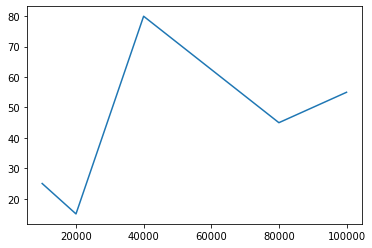

In [ ]:
plt.plot([10000, 20000, 40000, 80000, 100000], best_k)

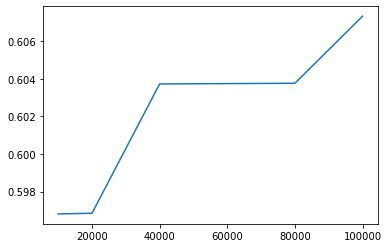

In [ ]:
plt.plot([10000, 20000, 40000, 80000, 100000], best_feature)

In [ ]:
# with lemmatization

t0 = time.time()
model = LinearDiscriminantAnalysis()
k_li = np.arange(10,301,5)
best_k = []
best_feature = []
for feature in [10000, 20000, 40000, 80000, 100000]:
    tfidf = TfidfVectorizer(analyzer='word', max_features=feature, ngram_range=(1,2), min_df=6, max_df=0.9,preprocessor=lemmatization)
    X_train_vect = tfidf.fit_transform(X_train)
    X_test_vect = tfidf.fit_transform(X_test)
    res = []
    for k in k_li:
        res.append(lda_k(k,X_train_vect,X_test_vect,y_train,y_test,model))
        
    idx = np.argmax(res)
    max_k = k_li[idx]
    max_feature = np.max(res)
    best_k.append(max_k)
    best_feature.append(max_feature)
    
print(best_k)
print(best_feature)
t1 = time.time()
print(f"time = {(t1-t0) /60} mins")

[250, 250, 230, 280, 240]
[0.5786165031072295, 0.5660556182066847, 0.5690068862921995, 0.5616407131031504, 0.5597691772440435]
time = 70.76012953122456 mins


In [ ]:
# with stemming

t0 = time.time()
model = LinearDiscriminantAnalysis()
k_li = np.arange(10,301,5)
best_k = []
best_feature = []
for feature in [10000, 20000, 40000]:
    tfidf = TfidfVectorizer(analyzer='word', max_features=feature, ngram_range=(1,2), min_df=6, max_df=0.9,preprocessor=stemmer)
    X_train_vect = tfidf.fit_transform(X_train)
    X_test_vect = tfidf.fit_transform(X_test)
    res = []
    for k in k_li:
        res.append(lda_k(k,X_train_vect,X_test_vect,y_train,y_test,model))
        
    idx = np.argmax(res)
    max_k = k_li[idx]
    max_feature = np.max(res)
    best_k.append(max_k)
    best_feature.append(max_feature)
    
print(best_k)
print(best_feature)
t1 = time.time()
print(f"time = {(t1-t0) /60} mins")

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x0000029CDDA594C0>
Traceback (most recent call last):
  File "C:\Users\cmial\anaconda3\lib\site-packages\nltk\data.py", line 1162, in __del__
    self.close()
  File "C:\Users\cmial\anaconda3\lib\site-packages\nltk\data.py", line 1191, in close
    self.stream.close()
KeyboardInterrupt: 


[245, 180, 295]
[0.5809559229311131, 0.5872183698442787, 0.5769969047676177]
time = 171.54700932502746 mins
